# INFO 2950 Project Phase 2
#### Talia Boehm, Lucy Barsanti, Emma Shen, Maddi Klancher


Link to dataset: https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

In [2]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

import seaborn
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression

In [3]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

# **Research Question:** 
* **Main Question**: How did the COVID-19 pandemic affect airline delays?

* **Supporting Questions**: What is the relationship between the COVID-19 rate and airline delays in the United States between January 2020 - July 2022? Does the relationship differ between states? By airline?

# **Data Cleaning:**

**Airline Delays Dataset**

* The data was exported as a CSV file. We did not remove any columns so that we could analyze all the different types of delays as well as geographic and carrier information. We basically did our “cleaning” by filtering on the BTS website to find flight delay information from January 2017 - July 2022.

**COVID-19 Cases Dataset**

* The data was exported as a CSV file. We removed unnecessary columns and added a couple of new columns to make our analysis easier. In addition, we compressed certain rows based on state, month, and year to ensure that our data were consistent with the airline delay dataset. The initial dataset was organized by day. A lot of these edits were made so as to ensure it was a fully usable dataset, and as well to ensure that there were no values that were null or would affect our analysis work. More specifically, our cleaning focused on:

* Converting objects to DateTime: This was a significant step, because much of our analysis required us to pull dates from the datasets. Unfortunately, the dates were not formatted within the CSV as DateTime objects, and thus our job was simply to transform these dates into DateTime objects. This was done using the pandas to_datetime() function, and assisted the team immensely in being able to directly pull the dates/times in a usable form for our data analysis. By being able to have these dates in DateTime objects, we are then able to use them without issue (in comparison to strings or other types) within our data analysis. 

* Adding month and year columns: In order to join the datasets by state, we needed to create new columns for the year and month of each record. This was simple since we already converted dates into DateTime objects. By adding these two columns, we were able to sum the covid cases and group by state, year, and month. 

* Removing all attributes except year	, month, state, tot_case, and new_case: We made the conscious decision to only use year, month, state, total cases, and new cases. We decided to omit the rest because our research question only pertains to COVID-19 cases, and not deaths. Moreover, we are not concerned with probable cases as the data is subjective based on whether or not consent was given to include those metrics. As a result, we decided to stick only with objective data for our analysis.

# Data Description

## Flight delay data from January 2017 - July 2022:

* This dataset contains information on flights in the United States from January 2017 to July 2022. The data contains attributes including the flight date, flight number, origin airport, destination airport, departure time, arrival time, and the reason for any delays. There are 7 reasons for flight delays outlined by the dataset: air carrier delay, weather delay, national aviation system delay, security delay, aircraft arriving late, canceled, and diverted. 

* Raw data can be found [here](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp) 
* Link to our [Google Drive](https://drive.google.com/file/d/1Ci4XzBpg3BF-_zx70sBTN1uVkaERmTgl/view?usp=sharing)

* **Observations**: Each observation in the dataset includes the number of occurrences of each cause of delay for one airline at one airport for one month. For example, one row in the dataset represents the flight delay statistics for American Airlines at Nashville International Airport for the month of July 2022. 

* **Attributes**: The attributes of this dataset are as follows:

**year:** Year data collected\
**month:** Numeric representation of the month\
**carrier:** Airline carrier number\
**carrier_name:** Airline carrer\
**airport:** Official airport code\
**airport_name:** Full airport name\
**arr_flights:** Number of flights arriving at airport\
**arr_del15:** Number of flights more than 15 minutes late\
**carrier_ct:** Number of flights delayed due to air carrier. (e.g. no crew)\
**weather_ct:** Number of flights due to weather\
**nas_ct:** Number of flights delayed due to National Aviation System\
**security_ct:** Number of flights canceled due to a security breach\
**late_aircraft_ct:** Number of flights delayed as a result of another flight on the same aircraft delayed\
**arr_cancelled:** Total number of canceled flights\
**arr_diverted:** Total number of diverted flights\
**arr_delay:** Total number of minutes of delay for arriving flights\
**carrier_delay:** Total number of minutes of delay due to carrier delays\
**weather_delay:** Total number of minutes of delay due to weather delays\
**nas_delay:** Total number of minutes of delay due to National Aviation System delays\
**security_delay:** Total number of minutes of delay due to security delays\
**late_aircraft_delay:** Total time (minutes) of delay as a result of a previous flight on the same airplane being late

* The U.S. Department of Transportation (DOT) created and funded the monthly Air Travel Consumer Report to provide information to the public about the quality of air travel. In response, the Bureau of Transportation Statistics (BTS) began collecting details on the causes of flight delays in June 2003. The air travel data found on the BTS website is publicly available and required by the U.S. Congress.

* Operating carriers that have a 0.5 percent of total domestic scheduled-service passenger revenue are required to report on-time data and the causes of delay. Our data comes from these 17 operating carriers reporting non-stop scheduled-service flights between points within the United States and including territories. The DOT’s framework determined the reporting categories to ensure the public would have clear information about the nature and sources of airline delays and cancellations. The Bureau of Transportation Statistics conducted a pilot program to test the monthly reporting of causation and then implemented this framework in 2001.

* The DOT defines a “delayed” flight if it operated more than 15 minutes later than the scheduled arrival time. As a result, the data on delayed flights abides by this definition. 

* We downloaded the data from the BTS website as a CSV file.

## COVID-19 cases and deaths by state over time from January 22, 2020 - October 20, 2022:

* The raw data can be found [here](https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36/data)

* Link to our [Google Drive](https://drive.google.com/file/d/1i3fQ9wMkgdViOwuJO_EKLR2p1Hd_UCyF/view?usp=sharing)

* This dataset contains archived aggregate daily counts of COVID-19 cases and death by state. 

* **Observations**: Each observation contains archived aggregate daily counts of COVID-19 cases and death for each state in the United States. For example, we can see one row that contains data from 10/18/22 for the state of New York with 3,275,131 total cases, 1,660 new cases, 29,356 total deaths, 32 new deaths, and 0 new probable deaths.

* **Attributes**: The attributes of this dataset are as follows:

**submission_date:** date of counts\
**state:** jurisdiction\
**tot_cases:** total number of cases\
**conf_cases:** total confirmed cases\
**prob_cases:** total probable cases\
**new_case:** number of new cases\
**pnew_case:** number of new probable cases\
**tot_death:** total number of deaths\
**conf_death:** total confirmed deaths\
**prob_death:** total probable deaths\
**new_death:** number of new deaths\
**pnew_death:** number of new probable deaths\
**created_at:** date and time record was created\
**consent_cases:** if agree, then confirmed and probable cases are included\
**consent_deaths:** if agree, then confirmed and probable deaths are included\
**year:** year or counts\
**month:** month of counts


* The Centers for Disease Control and Prevention (CDC) made the United States COVID-19 Cases and Deaths by State over Time dataset to track the spread of COVID-19 in the United States. The United States government funded this dataset. 

* We are using the data to compare flight delay information with COVID-19 cases on a monthly basis based on state to determine if there is any relationship between the two datasets.

* The CDC retrieves aggregate case and death data from jurisdictional and state partners. However, counting the exact number of COVID-19 cases is not possible due to a variety of reasons. For instance, people do not always report their illnesses, symptoms might not appear immediately, and there may be delays in testing. Moreover, there are sometimes false test results. Additionally, each state may have different testing and reporting protocols, population sentiment toward COVID-19, and levels of testing efficiency.

* We downloaded the data from the CDC’s website as a CSV file.

# Data Limitation

#### **First Data Set (Flight Delays)**:

* The data is somewhat limited because it does not include all flight data for the specified time period. Although the US has ​​19,622 airports, the data only includes information about 384 airports. Another limitation is that the data does not cover delays experienced by flights operated by US-based airlines but originating or arriving at airports outside the US. Although we are looking at the relationship between COVID-19 cases and delays in the US, international statistics could potentially affect our data too.

#### **Second Data Set (COVID-19 Cases)**:

* There are several limitations to any COVID-19 dataset. First, there is a lot of noise and misinformation surrounding the pandemic, making it difficult to separate fact from fiction. Secondly, different jurisdictions handle their data differently, making it difficult to get a complete picture of the pandemic within the United States. The data may also be affected by political and geographical demographics.

# Exploratory Data Analysis 

In [4]:
df_delays = pd.read_csv('Airline_Delay_Cause.csv')
df_delays.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.0,0.00,0.0,0.0,129.0,98.0,23.0,8.0,0.0,0.0
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,0.0,7.48,0.0,0.0,1664.0,887.0,52.0,224.0,0.0,501.0
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,0.0,5.40,5.0,4.0,1523.0,388.0,35.0,511.0,0.0,589.0
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,1.0,4.28,0.0,1.0,657.0,103.0,82.0,93.0,25.0,354.0
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,0.0,2.55,1.0,0.0,2462.0,1686.0,310.0,139.0,0.0,327.0


In [5]:
airports= df_delays['airport_name']
state = []
for x in airports:
    idx = x.rindex(":")
    start = idx - 2
    state_x = x[start: idx]
    state.append(state_x)

df_delays['state'] = state
df_delays.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.00,0.0,0.0,129.0,98.0,23.0,8.0,0.0,0.0,PA
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,7.48,0.0,0.0,1664.0,887.0,52.0,224.0,0.0,501.0,GA
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,5.40,5.0,4.0,1523.0,388.0,35.0,511.0,0.0,589.0,MA
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,4.28,0.0,1.0,657.0,103.0,82.0,93.0,25.0,354.0,LA
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,2.55,1.0,0.0,2462.0,1686.0,310.0,139.0,0.0,327.0,GA


In [6]:
df_covid = pd.read_csv('Covid-by-State.csv')
df_covid['submission_date']= pd.to_datetime(df_covid['submission_date'])
df_covid['year'] = pd.DatetimeIndex(df_covid['submission_date']).year
df_covid['month'] = pd.DatetimeIndex(df_covid['submission_date']).month
df_covid.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths,year,month
0,2021-03-11,KS,297229,241035.0,56194.0,0,0.0,4851,NaN,NaN,0,0.0,03/12/2021 03:20:13 PM,Agree,NaN,2021,3
1,2021-12-01,ND,163565,135705.0,27860.0,589,220.0,1907,NaN,NaN,9,0.0,12/02/2021 02:35:20 PM,Agree,Not agree,2021,12
2,2022-01-02,AS,11,NaN,NaN,0,0.0,0,NaN,NaN,0,0.0,01/03/2022 03:18:16 PM,NaN,NaN,2022,1
3,2021-11-22,AL,841461,620483.0,220978.0,703,357.0,16377,12727.0,3650.0,7,3.0,11/22/2021 12:00:00 AM,Agree,Agree,2021,11
4,2022-05-30,AK,251425,NaN,NaN,0,0.0,1252,NaN,NaN,0,0.0,05/31/2022 01:20:20 PM,NaN,NaN,2022,5


In [7]:

%sql df_covid_cleaned << SELECT year, month, state, SUM(tot_cases) AS tot_case, SUM(new_case) AS new_case FROM df_covid GROUP BY state, month, year ORDER BY year, month, state ASC

df_covid_cleaned


Returning data to local variable df_covid_cleaned


,year,month,state,tot_case,new_case
0,2020,1,AK,0,0
1,2020,1,AL,0,0
2,2020,1,AR,0,0
3,2020,1,AS,0,0
4,2020,1,AZ,6,1
...,...,...,...,...,...
2035,2022,10,VT,2394457,1530
2036,2022,10,WA,32827982,12770
2037,2022,10,WI,33758028,17572
2038,2022,10,WV,10850608,4454


In [74]:
## Lucy
dates = df_covid_cleaned[['year', 'month']]
month_date = []

for x in dates.index:
    if dates['month'][x] <= 9:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    else:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    
    month_date.append(float(month_date_x))
    
df_covid_cleaned['year_month'] = month_date

df_covid_cleaned.head()


,year,month,state,tot_case,new_case,year_month
0,2020,1,AK,0,0,2020.083333
1,2020,1,AL,0,0,2020.083333
2,2020,1,AR,0,0,2020.083333
3,2020,1,AS,0,0,2020.083333
4,2020,1,AZ,6,1,2020.083333


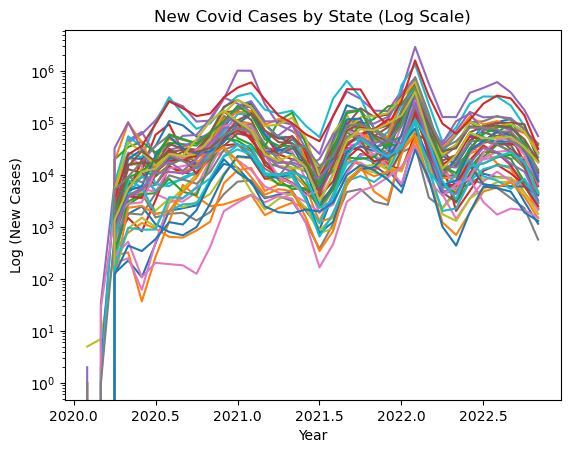

In [75]:
## Lucy
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

plt.yscale('log')
plt.title("New Covid Cases by State (Log Scale)")
plt.xlabel("Year")
plt.ylabel("Log (New Cases)")

for state in states:
    state_data_find = pd.Series(df_covid_cleaned['state'] == state)
    
    state_data = df_covid_cleaned.loc[state_data_find]
    x = state_data['year_month']
    y = state_data['new_case']
    
    plt.plot(x, y)

##print(ak_data)

In [8]:
## MADDI
%sql Endeavor_ABE_22_df << SELECT * FROM df_delays WHERE carrier = '9E' AND airport = 'ABE' AND year = 2022
Endeavor_ABE_22_df.head()

Returning data to local variable Endeavor_ABE_22_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.00,0.0,0.0,129.0,98.0,23.0,8.0,0.0,0.0,PA
1,2022,6,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",133.0,14.0,9.28,0.03,...,3.04,3.0,0.0,853.0,625.0,2.0,56.0,0.0,170.0,PA
2,2022,5,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",136.0,7.0,5.95,0.00,...,1.00,0.0,0.0,255.0,222.0,0.0,4.0,0.0,29.0,PA
3,2022,4,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",132.0,6.0,2.00,0.00,...,0.18,0.0,0.0,170.0,58.0,0.0,101.0,0.0,11.0,PA
4,2022,3,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",135.0,12.0,4.21,1.93,...,1.78,0.0,1.0,513.0,124.0,180.0,107.0,25.0,77.0,PA


[Text(0.5, 1.0, 'Endeavor Air Inc. Delays at ABE from Jan-Jul 2022')]

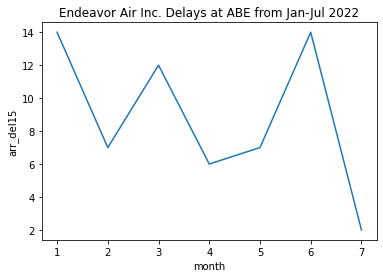

In [9]:
## MADDI
seaborn.lineplot(data=Endeavor_ABE_22_df, x="month", y="arr_del15").set(title='Endeavor Air Inc. Delays at ABE from Jan-Jul 2022')

In [77]:
## MADDI
%sql Delta_LAX_Jan_df << SELECT * FROM df_delays WHERE carrier = 'DL' AND airport = 'LAX'
Delta_LAX_Jan_df.head()

dates = Delta_LAX_Jan_df[['year', 'month']]
month_date = []

for x in dates.index:
    if dates['month'][x] <= 9:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    else:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    
    month_date.append(float(month_date_x))
    
Delta_LAX_Jan_df['year_month'] = month_date

Delta_LAX_Jan_df.head()

Returning data to local variable Delta_LAX_Jan_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,year_month
0,2022,7,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2934.0,488.0,221.01,12.42,...,26.0,1.0,38128.0,20967.0,842.0,3984.0,0.0,12335.0,CA,2022.583333
1,2022,6,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2855.0,604.0,302.15,16.86,...,104.0,3.0,39156.0,22502.0,1213.0,5618.0,55.0,9768.0,CA,2022.500000
2,2022,5,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2582.0,462.0,214.30,11.48,...,79.0,0.0,29272.0,15948.0,1044.0,5573.0,0.0,6707.0,CA,2022.416667
3,2022,4,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2394.0,477.0,193.98,8.25,...,14.0,0.0,30748.0,15994.0,1142.0,6193.0,51.0,7368.0,CA,2022.333333
4,2022,3,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2440.0,432.0,162.50,13.55,...,12.0,2.0,28342.0,12323.0,1432.0,6798.0,0.0,7789.0,CA,2022.250000


(array([2019.5, 2020. , 2020.5, 2021. , 2021.5, 2022. , 2022.5, 2023. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

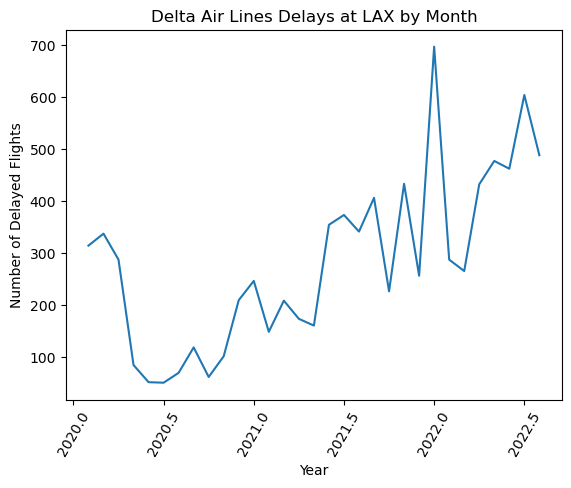

In [79]:
## MADDI
seaborn.lineplot(data=Delta_LAX_Jan_df, x="year_month", y="arr_del15").set(title='Delta Air Lines Delays at LAX by Month')
plt.xlabel('Year')
plt.ylabel('Number of Delayed Flights')
plt.xticks(rotation=60)

In [12]:
## LUCY
%sql df_covid_flight << SELECT df_delays.*, df_covid_cleaned.tot_case, df_covid_cleaned.new_case FROM df_delays INNER JOIN df_covid_cleaned ON df_delays.month = df_covid_cleaned.month AND df_delays.year = df_covid_cleaned.year AND df_delays.State = df_covid_cleaned.state

df_covid_flight

Returning data to local variable df_covid_flight


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,tot_case,new_case
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.0,129.0,98.0,23.0,8.0,0.0,0.0,PA,94451196,83892
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,0.0,1664.0,887.0,52.0,224.0,0.0,501.0,GA,83574171,103347
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,4.0,1523.0,388.0,35.0,511.0,0.0,589.0,MA,60291430,42217
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,1.0,657.0,103.0,82.0,93.0,25.0,354.0,LA,39327318,54312
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,0.0,2462.0,1686.0,310.0,139.0,0.0,327.0,GA,83574171,103347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50634,2020,1,YV,Mesa Airlines Inc.,RIC,"Richmond, VA: Richmond International",5.0,1.0,1.00,0.00,...,0.0,131.0,131.0,0.0,0.0,0.0,0.0,VA,0,0
50635,2020,1,YV,Mesa Airlines Inc.,ROA,"Roanoke, VA: Roanoke Blacksburg Regional Woodr...",1.0,1.0,0.00,0.00,...,0.0,61.0,0.0,0.0,0.0,0.0,61.0,VA,0,0
50636,2020,1,YX,Republic Airline,BTV,"Burlington, VT: Burlington International",173.0,22.0,4.36,0.00,...,2.0,951.0,224.0,0.0,207.0,0.0,520.0,VT,0,0
50637,2020,1,YX,Republic Airline,ORF,"Norfolk, VA: Norfolk International",93.0,13.0,3.68,0.00,...,0.0,569.0,153.0,0.0,79.0,0.0,337.0,VA,0,0


## VI. Questions for reviewers 

### A. Instructions from student handbook
Have an initial dra of your data description section.
Perform and initial exploratory data analysis 
List specific questions for your peer reviewers
and project mentor to answer in giving you feedback on this phase.
